Import all the libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns   
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor

Handle missing values using simple imputer

In [2]:
df= pd.read_csv("insurance.csv")
print(df.head())
# print(df.info())
print(df.isnull().sum())

# in case of missing data
numerical_cols = ['age', 'bmi', 'children']
imputer_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
df[numerical_cols] = imputer_mean.fit_transform(df[numerical_cols])


   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


label encoding and preprocessing

In [3]:
# label encoder
le = LabelEncoder()
df['sex'] = le.fit_transform(df['sex'])       # male/female -> 0/1
df['smoker'] = le.fit_transform(df['smoker']) # yes/no -> 1/0

# the person who is smoker and his BMI high his cost will be higher
df['smoker_bmi'] = df['smoker'] * df['bmi']

target='charges'
features=['age', 'sex', 'bmi', 'children', 'smoker', 'region','smoker_bmi']
x= df[features].values
y= df[target]
#preprocessing 

ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [5])], remainder='passthrough')
x = np.array(ct.fit_transform(x))

Splitting dataset, feature scaling, creating LINEAR REGRESSION model and fitting it

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
scaler= StandardScaler()
x_train= scaler.fit_transform(x_train)
x_test= scaler.transform(x_test)
y_train=scaler.fit_transform(y_train.values.reshape(-1,1)).flatten()
y_test=scaler.transform(y_test.values.reshape(-1,1)).flatten()

#Training model
model= LinearRegression()
model.fit(x_train, y_train)

#Predicting test set results
y_pred= model.predict(x_test)
mse= mean_squared_error(y_test, y_pred)
print("Linear regression Mean Squared Error:{:.2f}".format(mse))

r2= r2_score(y_test,y_pred)
print("Linear regression R2 Score:{:.2f}".format(r2))

Linear regression Mean Squared Error:0.13
Linear regression R2 Score:0.88


Plotting linear regression model

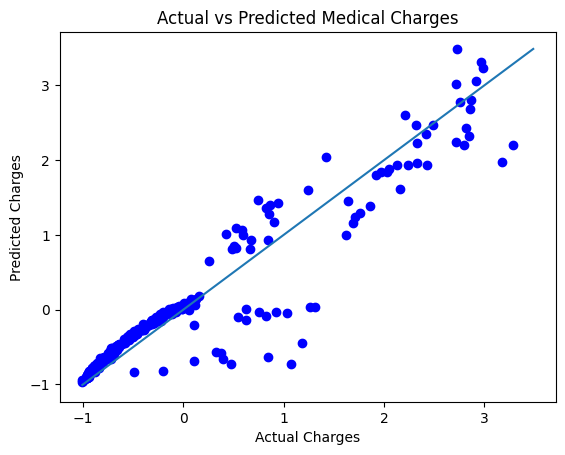

In [5]:
min_val= min(min(y_test), min(y_pred))
max_val= max(max(y_test), max(y_pred))
plt.scatter(y_test, y_pred, color='blue')
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Actual vs Predicted Medical Charges")
plt.plot([min_val, max_val], [min_val, max_val])
plt.show(block=False)

Preparing the KNN model and predicting results


In [6]:
k_best = 1
score_best = -10000
mse_values = []

for k in range(1,20):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(x_train,y_train)
    score= knn.score(x_test,y_test)
    mse_values.append(mean_squared_error(y_test, knn.predict(x_test)))
    if score > score_best:
        k_best = k
        score_best = score

# we found the best k let's train the model
knn = KNeighborsRegressor(n_neighbors=k_best)
knn.fit(x_train,y_train)


#Predicting test set results
knn_y_pred = knn.predict(x_test)
mse= mean_squared_error(y_test, knn_y_pred)
print("KNN Mean Squared Error:{:.2f}".format(mse))

r2= r2_score(y_test,knn_y_pred)
print("KNN R2 Score:{:.2f}".format(r2))


KNN Mean Squared Error:0.16
KNN R2 Score:0.86


Plotting the KNN and the comparison graph between knn and linear

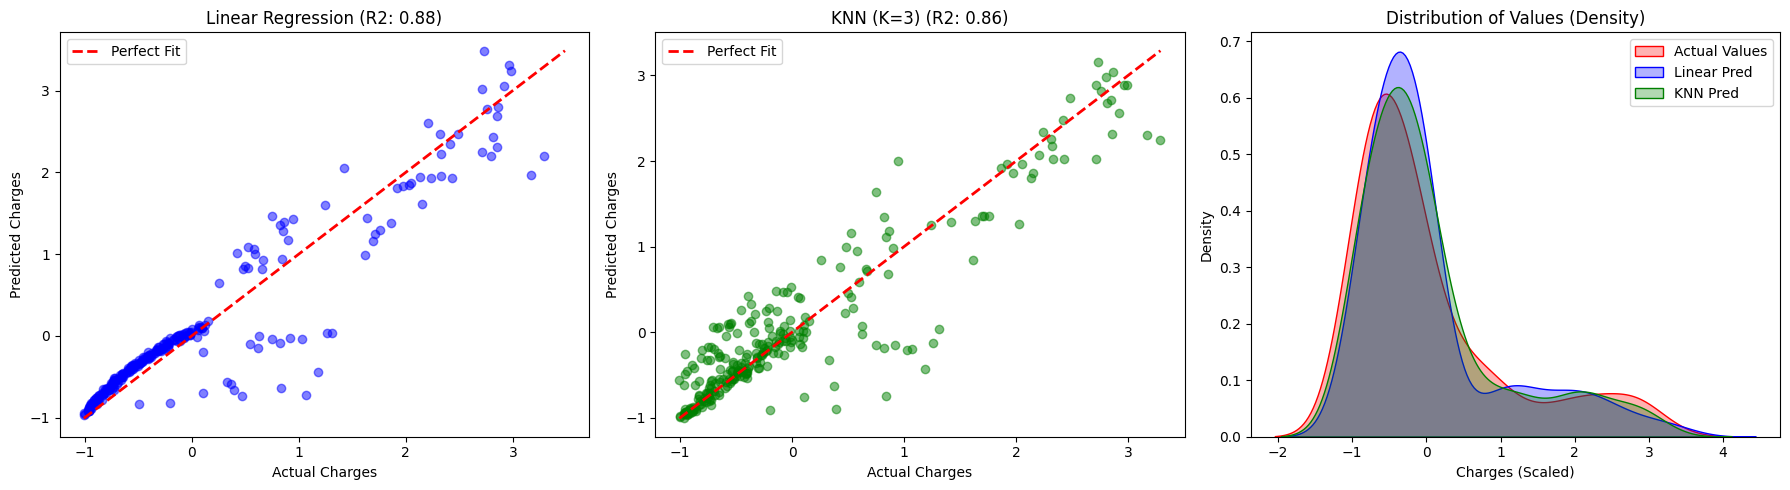

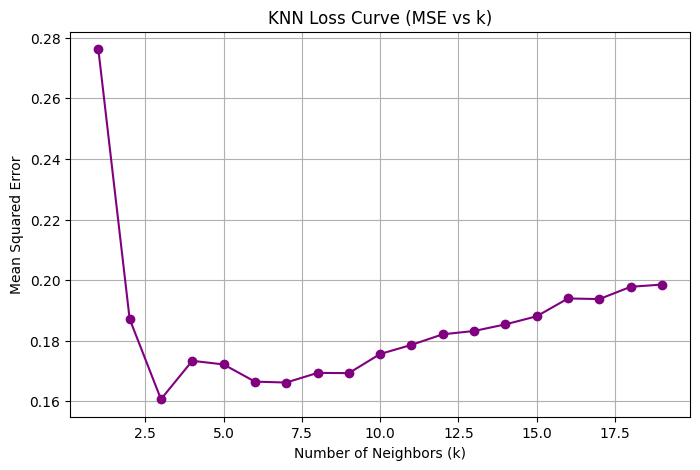

In [7]:
# Plotting
# Set up the figure with 3 columns (1 row, 3 plots)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# --- Plot 1: Linear Regression (Scatter + Line) ---
min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))

axes[0].scatter(y_test, y_pred, color='blue', alpha=0.5)
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Fit')
axes[0].set_title(f"Linear Regression (R2: {r2_score(y_test, y_pred):.2f})")
axes[0].set_xlabel("Actual Charges")
axes[0].set_ylabel("Predicted Charges")
axes[0].legend()

# --- Plot 2: KNN Regression (Scatter + Line) ---
min_val_knn = min(min(y_test), min(knn_y_pred))
max_val_knn = max(max(y_test), max(knn_y_pred))

axes[1].scatter(y_test, knn_y_pred, color='green', alpha=0.5)
axes[1].plot([min_val_knn, max_val_knn], [min_val_knn, max_val_knn], 'r--', linewidth=2, label='Perfect Fit')
axes[1].set_title(f"KNN (K={k_best}) (R2: {r2_score(y_test, knn_y_pred):.2f})")
axes[1].set_xlabel("Actual Charges")
axes[1].set_ylabel("Predicted Charges")
axes[1].legend()

sns.kdeplot(y_test, color='red', label='Actual Values', fill=True, alpha=0.3, ax=axes[2])
sns.kdeplot(y_pred, color='blue', label='Linear Pred', fill=True, alpha=0.3, ax=axes[2])
sns.kdeplot(knn_y_pred, color='green', label='KNN Pred', fill=True, alpha=0.3, ax=axes[2])

axes[2].set_title("Distribution of Values (Density)")
axes[2].set_xlabel("Charges (Scaled)")
axes[2].legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(1, 20), mse_values, marker='o', color='purple')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Mean Squared Error")
plt.title("KNN Loss Curve (MSE vs k)")
plt.grid(True)
plt.show()